# Artifact 1
For this artifact/experiment, we have a series of different **Weak Scaling** tests for the following:
1. FLoX (using **Parsl** for the execution engine)
2. FLoX (using **Parsl** for the execution engine and **ProxyStore's** `RedisConnector` for data transfer)
3. Flower

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from parse_results import *
from plot_style import *

MODEL_ORDER = ["DebugNet", "KyleNet", "SqueezeNet", "ResNet-18", "ResNet-50", "ResNet-152"]
MODEL_ORDER_2 = ["TinyNet", "SmallNet", "SqueezeNet", "ResNet-18", "ResNet-50", "ResNet-152"]

### Loading Experiment Data
First, we load the results from each of the weak scaling tests and parse them into a `pandas` DataFrame.

The parsing logic is provided in `parse_results.py`.

#### FLoX Results w/Parsl

In [2]:
parsl_df = (
    parse_parsl_results([
        Path("results/parsl-results/round3_sync"),
        Path("results/parsl-results/parsl_squeeze_net"),
    ])
    .rename(columns={"prime2end": "time"})
    .rename(columns={"num_workers": "workers"})
    .drop(columns=["start", "priming_done", "end", "start2end"])
    .replace({"KyleNet": "SmallNet", "DebugNet": "TinyNet"})
    .assign(backend="parsl")
)
parsl_df.head()

,model,workers,time,backend
0,ResNet-50,16,30.241880,parsl
1,ResNet-50,32,69.040634,parsl
2,TinyNet,16,2.580433,parsl
3,SmallNet,512,21.121526,parsl
4,TinyNet,2048,32.644537,parsl


#### FLoX Results w/Parsl and RedisConnector

In [3]:
redis_df = (
    parse_parsl_results([
        Path("results/parsl-results/sync_evict_redis_round_2"),
    ])
    .rename(columns={"prime2end": "time"})
    .rename(columns={"num_workers": "workers"})
    .drop(columns=["start", "priming_done", "end", "start2end"])
    .replace({"KyleNet": "SmallNet", "DebugNet": "TinyNet"})
    .assign(backend="parsl+redis")
)
redis_df.head()

,model,workers,time,backend
0,ResNet-18,512,206.237590,parsl+redis
1,ResNet-152,4,15.782564,parsl+redis
2,ResNet-152,8,27.258080,parsl+redis
3,TinyNet,512,16.225449,parsl+redis
4,ResNet-152,32,94.895457,parsl+redis


#### Flower Results

In [4]:
flwr_df = (
    parse_flower_results([
        Path("results/flower-results/single_node/"),
        Path("results/flower-results/multi_node/"),
    ])
    .replace({"KyleNet": "SmallNet", "DebugNet": "TinyNet"})
    .assign(backend="flower")
)
flwr_df.head()

,model,workers,time,backend
0,SmallNet,2,3.184818,flower
1,SqueezeNet,16,7.899091,flower
2,ResNet-152,64,300.489048,flower
3,TinyNet,16,3.877657,flower
4,ResNet-18,32,24.103717,flower


#### Merging Results
For simplicity, we combine all the results loaded above into one single DataFrame, `df`.

In [5]:
df = (
    pd.concat([flwr_df, parsl_df, redis_df]).reset_index(drop=True)
    .replace({
        "parsl": "Parsl", 
        "flower": "Flower", 
        "parsl+redis": "Parsl+RedisConnector"
    })
)
df.head()

,model,workers,time,backend
0,SmallNet,2,3.184818,Flower
1,SqueezeNet,16,7.899091,Flower
2,ResNet-152,64,300.489048,Flower
3,TinyNet,16,3.877657,Flower
4,ResNet-18,32,24.103717,Flower


### Plotting Results
...

In [6]:
def make_comparison_plot(df: pd.DataFrame, outfile: str, yscale: str="linear"):
    """This function standardizes how plots look for comparing Parsl, Parsl w/Redis, and Flower.

    Args:
        df (pd.DataFrame): The DataFrame to use for plotting.
        outfile (str): The filename to use for saving the plot to disk.
        yscale (str, optional): The scale to set the y-axis to. Defaults to "linear".
    """
    axes_w_legend = (0, 1)
    backend_order = ["Parsl", "Flower", "Parsl+RedisConnector"]
    with sns.plotting_context("paper", font_scale=1.0):
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4), sharey=False)
        for n, model in enumerate(MODEL_ORDER_2):
            i = n // 3
            j = n % 3
            ax = axes[i, j]
            tmp = df.query(f"model == '{model}'")
            sns.lineplot(
                tmp,
                x="workers",
                y="time",
                hue="backend",
                style="backend",
                markers=True,
                markersize=8,
                hue_order=backend_order,
                style_order=backend_order,
                linewidth=2,
                ax=ax,
            )
            
            ax.set(xscale="log", yscale=yscale)
        
        ticks = [2, 8, 32, 128, 512, 2048]
        axes[0, 0].set_xticks(ticks, ticks, rotation=45)
        
        ticks = [2, 8, 32, 128, 512, 2048]
        axes[0, 1].set_xticks(ticks, ticks, rotation=45)
        
        ticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
        axes[0, 2].set_xticks(ticks, ticks, rotation=45)
        
        ticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
        axes[1, 0].set_xticks(ticks, ticks, rotation=45)
        
        ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
        axes[1, 1].set_xticks(ticks, ticks, rotation=45)
        
        ticks = [2, 4, 8, 16, 32, 64, 128, 256]
        axes[1, 2].set_xticks(ticks, ticks, rotation=45)
        
        for n in range(0, 6):
            i, j = n//3, n%3
            
            # Set the title.
            axes[i, j].set_title(MODEL_ORDER_2[n])
            axes[i, j].minorticks_off()
            
            # Change the Y-label.
            if j % 3 == 0:
                axes[i, j].set_ylabel("Runtime (sec.)", weight="bold")
            else:
                axes[i, j].set_ylabel("")
                
            # Change the X-label.
            if i == 1:
                axes[i, j].set_xlabel("# Workers", weight="bold")
            else:
                axes[i, j].set_xlabel("")
                
            if axes_w_legend == (i, j):
                handles, labels = axes[i, j].get_legend_handles_labels()
            axes[i, j].get_legend().remove()
            
            
        legend = fig.legend(
            handles, labels,
            bbox_to_anchor=(0.75, 1.1),
            frameon=False, title="Backend", ncols=3
        )
        plt.setp(legend.get_title(), weight="bold")
        plt.tight_layout()
        plt.savefig(outfile, bbox_inches="tight")
        plt.show()

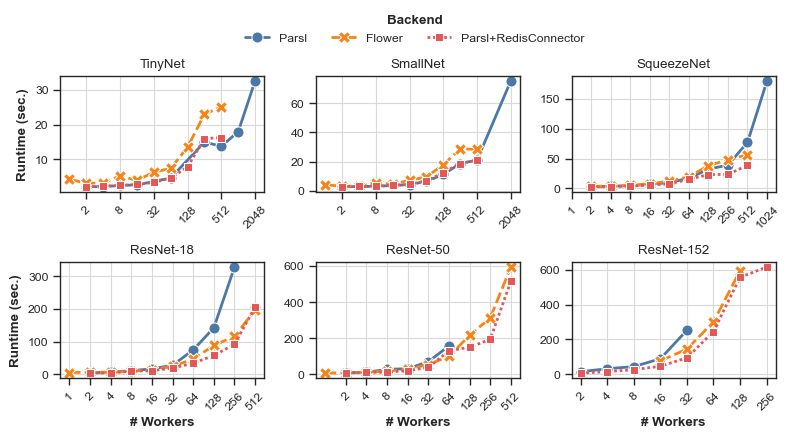

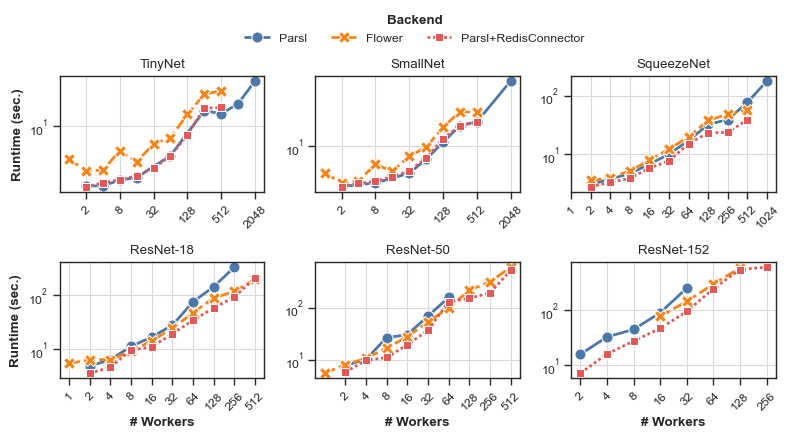

In [7]:
make_comparison_plot(df, "artifact_1_linear.pdf", "linear")
make_comparison_plot(df, "artifact_1_log.pdf", "log")